In [25]:
# Import packages
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from torch import nn

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)
torch.manual_seed(189898)

mps


## Part 1: (5 pts)
Load the CIFAR10 dataset and display one image of each class. Set up your dataloader using torchvision.transforms. Take into account the required preprocessing transformations expected by the model (ResNet18). Additionally include a data augmentation strategy and report it.

In [26]:
# Fix certificate errors
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
# Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [27]:
# Download the dataset and display classes
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=False, transform=transform_flip)
test_dataset = torchvision.datasets.CIFAR10(root="../data", train=False, transform=preprocess)
classes = trainset.class_to_idx
print(classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [28]:
# Print the dataset shape
trainset.data.shape

(50000, 32, 32, 3)

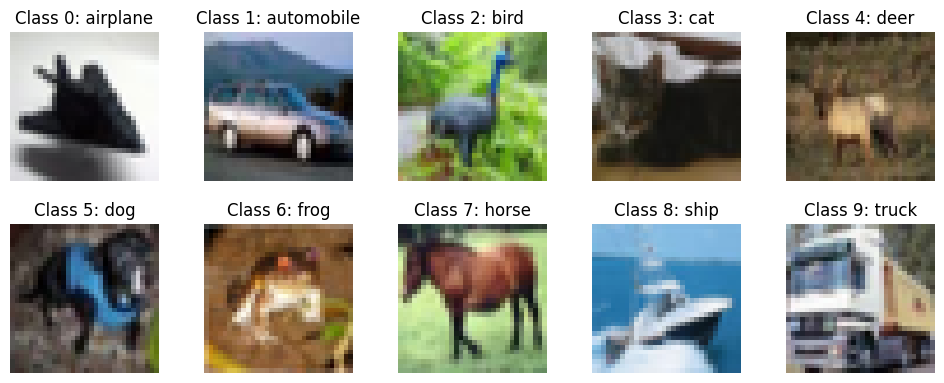

In [29]:
# Get the index of one image from each class
class_names = []
for c in classes:
    class_names.append(c)
indices = [-1 for i in range(10)]
for i, (image, label) in enumerate(trainset):
    if indices[label] < 0:
        indices[label] = i

# Display one image from each class
fig, axs = plt.subplots(2, 5, figsize=(10,4))
fig.tight_layout(h_pad=1, w_pad=0)
for i, index in enumerate(indices):
    if i <= 4:
        row = 0
        col = i
    else:
        row = 1
        col = i - 5
    axs[row,col].imshow(trainset.data[index])
    axs[row,col].set_title(f"Class {trainset.targets[index]}: {class_names[i]}")
    axs[row,col].axis('off')

In [30]:
# Set up the dataloader
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Part 2: (5 pts)
Download an image of any of the classes present in the ImageNet dataset and make sure the pretrained model is able to classify it correctly. Then, try a transformation or noise injection that can trick the network.

In [37]:
# import the pretrained model and send it to device
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# get the ImageNet labels
with open('../data/imagenet_classes.txt') as f:
    imagenet_labels = [line.strip() for line in f.readlines()]
imagenet_labels

['0, tench',
 '1, goldfish',
 '2, great_white_shark',
 '3, tiger_shark',
 '4, hammerhead',
 '5, electric_ray',
 '6, stingray',
 '7, cock',
 '8, hen',
 '9, ostrich',
 '10, brambling',
 '11, goldfinch',
 '12, house_finch',
 '13, junco',
 '14, indigo_bunting',
 '15, robin',
 '16, bulbul',
 '17, jay',
 '18, magpie',
 '19, chickadee',
 '20, water_ouzel',
 '21, kite',
 '22, bald_eagle',
 '23, vulture',
 '24, great_grey_owl',
 '25, European_fire_salamander',
 '26, common_newt',
 '27, eft',
 '28, spotted_salamander',
 '29, axolotl',
 '30, bullfrog',
 '31, tree_frog',
 '32, tailed_frog',
 '33, loggerhead',
 '34, leatherback_turtle',
 '35, mud_turtle',
 '36, terrapin',
 '37, box_turtle',
 '38, banded_gecko',
 '39, common_iguana',
 '40, American_chameleon',
 '41, whiptail',
 '42, agama',
 '43, frilled_lizard',
 '44, alligator_lizard',
 '45, Gila_monster',
 '46, green_lizard',
 '47, African_chameleon',
 '48, Komodo_dragon',
 '49, African_crocodile',
 '50, American_alligator',
 '51, triceratops',
 

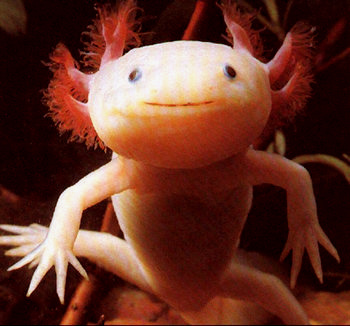

In [34]:
# open the image from ImageNet
axolotl = Image.open("../data/axolotl.JPEG")
axolotl

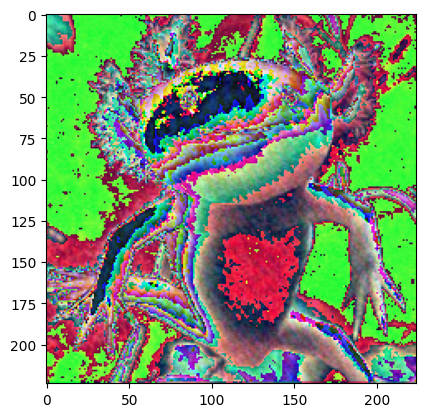

In [35]:
# preprocess the axolotl image from ImageNet
axolotlT = preprocess(axolotl)
plt.imshow(transforms.ToPILImage()(axolotlT))

In [38]:
# use the model to predict for the image
model.eval()
outputA = model(axolotlT.unsqueeze(0).to(device))
probs = torch.nn.Softmax(dim=1)(outputA)
probs.shape

torch.Size([1, 1000])

'29, axolotl'

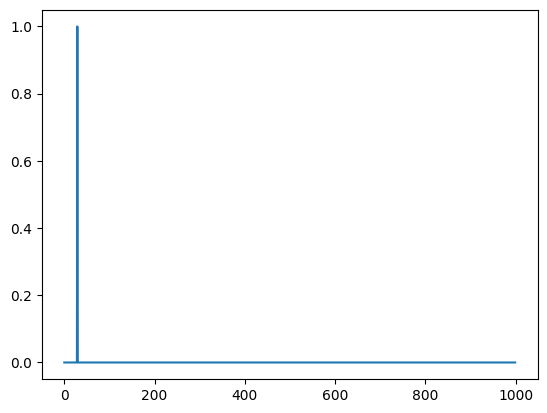

In [41]:
# plot the guess of the model for the image
plt.plot(probs.detach().cpu()[0])
imagenet_labels[probs.argmax()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'488, chain'

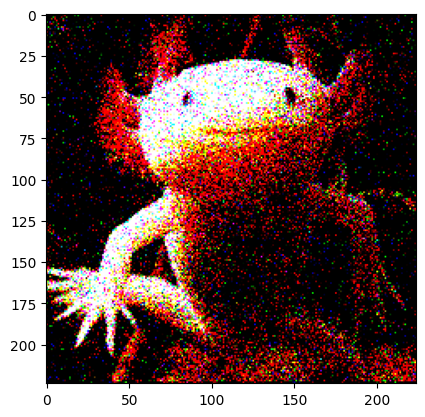

In [42]:
# noise injection to trick the model
noise = np.random.normal(0, 1, axolotlT.unsqueeze(0).size())
noisy = axolotlT.unsqueeze(0) + torch.tensor(noise, dtype=torch.float32)
with torch.no_grad():
    output = model(noisy.to(device))
probs = torch.nn.Softmax(dim=1)(output)
plt.imshow(noisy.squeeze(0).permute(1, 2, 0).numpy())
imagenet_labels[probs.argmax()]

## Part 3: (5 pts)
Now we will retrain the model for CIFAR10. Freeze all of the layers except for the last fully connected layer. Allow this last layer to adapt to the CIFAR10 dataset during the training. Create a validation set and implement an early stopping strategy. Plot the validation accuracy vs epochs and report your selection of hyper-parameters.

In [ ]:
# modify the pretrained model's final layer
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 10)
model.fc.requires_grad_ = True

In [57]:
# Initialize the optimizer, loss function, and early stopping check
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

def early_stopping_check(val_acc, patience, best_val_acc, counter):
    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
    return counter, counter >= patience, best_val_acc

In [48]:
# Split the training set to training and validation dataloaders
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
batch_size = 128

train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [58]:
# Train the model
import time
num_epochs = 50
patience = 5
best_val_accuracy = 0
counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
runtime_start = time.time()

for epoch in range(num_epochs):
    epoch_time = time.time()
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    history['train_loss'].append(train_loss)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for input, label in val_loader:
            input, label = input.to(device), label.to(device)
            output = model(input)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch: [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f} - Duration: {(time.time() - epoch_time):.2f}")
    counter, stop, best_val_accuracy = early_stopping_check(val_accuracy, patience, best_val_accuracy, counter)
    if stop:
        print(f"Validation Accuracy has not improved in at least {patience} epochs. Early Stopping triggered.")
        break

# Check the test accuracy and runtime
runtime = time.time() - runtime_start
print(f"Runtime: {runtime:.2f}")
total = 0
correct = 0
with torch.no_grad():
    for input, label in test_loader:
        input, label = input.to(device), label.to(device)
        output = model(input)
        loss = criterion(output, label)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch: [1/50] - Train Loss: 5.2695 - Validation Loss: 4.7955 - Validation Accuracy: 78.56 - Duration: 109.40
Epoch: [2/50] - Train Loss: 4.3746 - Validation Loss: 4.6970 - Validation Accuracy: 78.41 - Duration: 106.89
Epoch: [3/50] - Train Loss: 4.2723 - Validation Loss: 4.6427 - Validation Accuracy: 78.81 - Duration: 109.17
Epoch: [4/50] - Train Loss: 4.1979 - Validation Loss: 4.5510 - Validation Accuracy: 79.18 - Duration: 110.91
Epoch: [5/50] - Train Loss: 4.1614 - Validation Loss: 4.5404 - Validation Accuracy: 79.30 - Duration: 111.12
Epoch: [6/50] - Train Loss: 4.1753 - Validation Loss: 4.4187 - Validation Accuracy: 79.50 - Duration: 109.21
Epoch: [7/50] - Train Loss: 4.1296 - Validation Loss: 4.4355 - Validation Accuracy: 79.55 - Duration: 106.38
Epoch: [8/50] - Train Loss: 3.9974 - Validation Loss: 4.3613 - Validation Accuracy: 79.80 - Duration: 106.27
Epoch: [9/50] - Train Loss: 4.0588 - Validation Loss: 4.4536 - Validation Accuracy: 79.46 - Duration: 106.60
Epoch: [10/50] - Tr

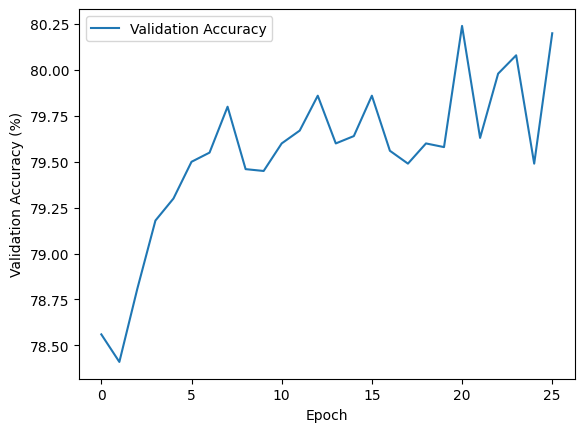

In [74]:
# Plots
hist_epochs = [i for i in range(len(history['val_accuracy']))]
plt.figure()
plt.plot(hist_epochs, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

## Part 4: (5 pts)
Finally, retrain the network in a similar way as in the previous part. In this case, unfreeze the first convolutional layer and the first convolutional layer present in the first "BasicBlock", in addition to the final fully connected layer. Plot and compare the filters of the first convolutional layer for the original model with the new filters learned after you retrain it. Again, use early stopping on your validation set and plot the validation accuracy vs epochs. Report how you selected your hyperparameters.

In [70]:
# reinitialize the model
model_unfreeze = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
# freeze all the layers and change the fully connected layer
for param in model_unfreeze.parameters():
    param.requires_grad = False
model_unfreeze.fc = torch.nn.Linear(512, 10)

# unfreeze the first convolutional layer, BB1 conv1, and fc
model_unfreeze.conv1.requires_grad_ = True
model_unfreeze.layer1[0].conv1.requires_grad_ = True
model_unfreeze.fc.requires_grad_ = True
model_unfreeze.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
# get an image and pass it to the unmodified network
check_image, check_label = next(iter(train_loader))
image0 = check_image[0].unsqueeze(0).to(device)
before = model_unfreeze.conv1(image0)[0, 10].detach().cpu()
original_conv1_weights = model.conv1.weight.detach().cpu().numpy()

In [71]:
criterion_unfreeze = torch.nn.CrossEntropyLoss()
optimizer_unfreeze = torch.optim.SGD(filter(lambda p: p.requires_grad, model_unfreeze.parameters()), lr=0.001, momentum=0.0)

In [72]:
# define the loss and optimizer
best_val_accuracy = 0
counter = 0
history_unfreeze = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
runtime_start = time.time()

for epoch in range(num_epochs):
    epoch_time = time.time()
    model_unfreeze.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_unfreeze.zero_grad()
        outputs = model_unfreeze(inputs)
        loss = criterion_unfreeze(outputs, labels)
        loss.backward()
        optimizer_unfreeze.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    history_unfreeze['train_loss'].append(train_loss)
    
    model_unfreeze.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for input, label in val_loader:
            input, label = input.to(device), label.to(device)
            output = model_unfreeze(input)
            loss = criterion_unfreeze(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    history_unfreeze['val_loss'].append(val_loss)
    history_unfreeze['val_accuracy'].append(val_accuracy)
    print(f"Epoch: [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f} - Duration: {(time.time() - epoch_time):.2f}")
    counter, stop, best_val_accuracy = early_stopping_check(val_accuracy, patience, best_val_accuracy, counter)
    if stop:
        print(f"Validation Accuracy has not improved in at least {patience} epochs. Early Stopping triggered.")
        break

# Check the test accuracy and runtime
runtime = time.time() - runtime_start
print(f"Runtime: {runtime:.2f}")
total = 0
correct = 0
with torch.no_grad():
    for input, label in test_loader:
        input, label = input.to(device), label.to(device)
        output = model_unfreeze(input)
        loss = criterion_unfreeze(output, label)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch: [1/50] - Train Loss: 2.0841 - Validation Loss: 1.8077 - Validation Accuracy: 44.55 - Duration: 108.64
Epoch: [2/50] - Train Loss: 1.6394 - Validation Loss: 1.4783 - Validation Accuracy: 60.30 - Duration: 107.61
Epoch: [3/50] - Train Loss: 1.3834 - Validation Loss: 1.2774 - Validation Accuracy: 66.93 - Duration: 106.92
Epoch: [4/50] - Train Loss: 1.2240 - Validation Loss: 1.1492 - Validation Accuracy: 69.62 - Duration: 106.72
Epoch: [5/50] - Train Loss: 1.1165 - Validation Loss: 1.0536 - Validation Accuracy: 72.09 - Duration: 106.64
Epoch: [6/50] - Train Loss: 1.0403 - Validation Loss: 0.9974 - Validation Accuracy: 72.33 - Duration: 112.68
Epoch: [7/50] - Train Loss: 0.9823 - Validation Loss: 0.9431 - Validation Accuracy: 73.79 - Duration: 110.81
Epoch: [8/50] - Train Loss: 0.9393 - Validation Loss: 0.9039 - Validation Accuracy: 74.42 - Duration: 113.45
Epoch: [9/50] - Train Loss: 0.9032 - Validation Loss: 0.8708 - Validation Accuracy: 75.17 - Duration: 116.41
Epoch: [10/50] - Tr

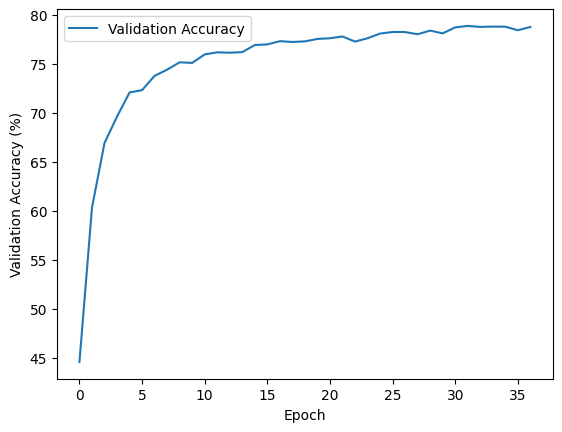

In [75]:
# Plots
unfrozen_epochs = [i for i in range(len(history_unfreeze['val_accuracy']))]
plt.figure()
plt.plot(unfrozen_epochs, history_unfreeze['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

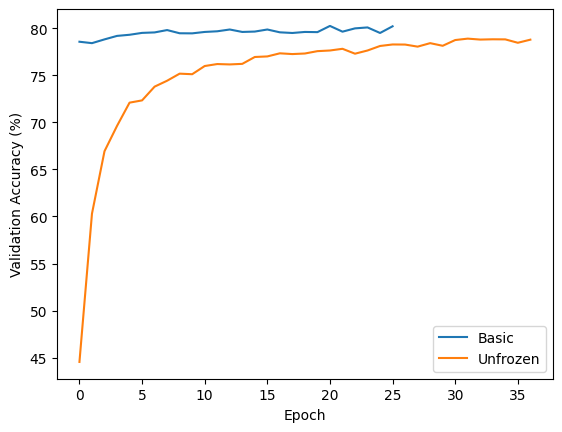

In [76]:
# Plots with comparison
plt.figure()
plt.plot(hist_epochs, history['val_accuracy'], label='Basic')
plt.plot(unfrozen_epochs, history_unfreeze['val_accuracy'], label='Unfrozen')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

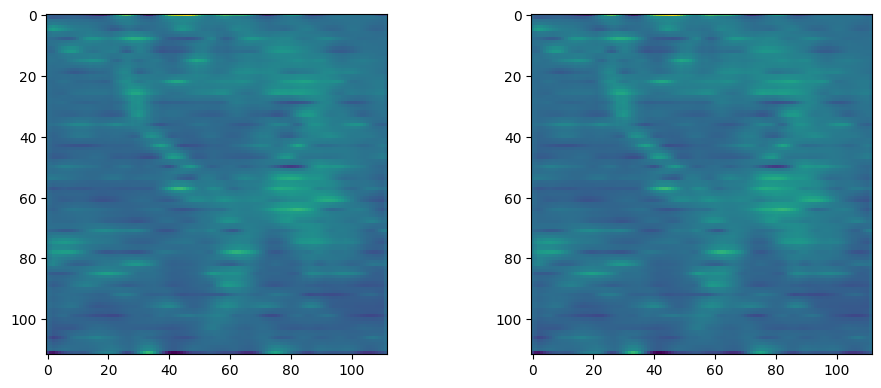

In [88]:
# Compare the filters of the first convolutional layer
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.tight_layout(h_pad=1, w_pad=0)
axs[0].imshow(before)
axs[1].imshow(model_unfreeze.conv1(image0)[0, 10].detach().cpu())
retrained_conv1_weights = model.conv1.weight.detach().cpu().numpy()

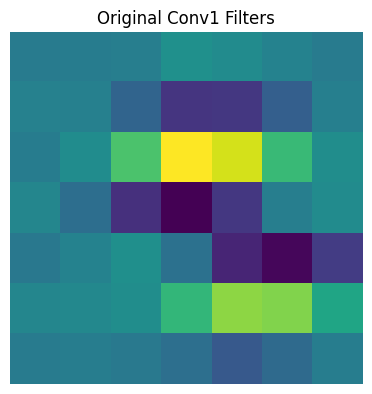

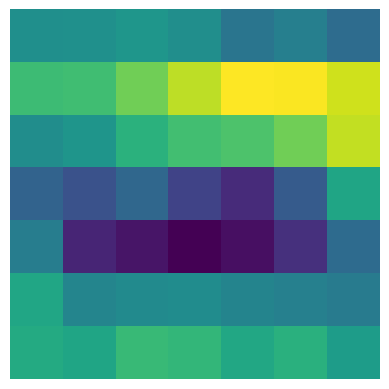

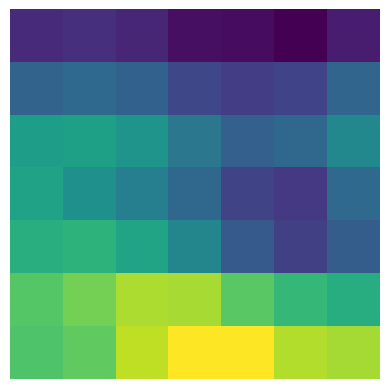

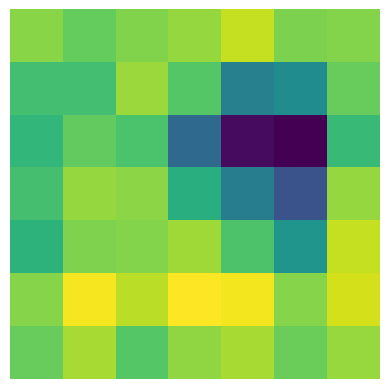

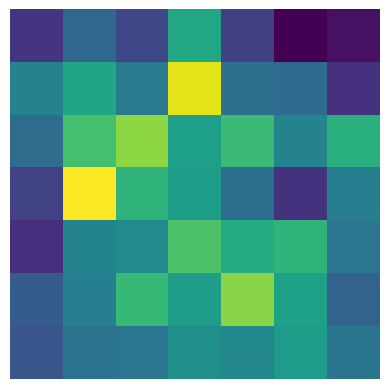

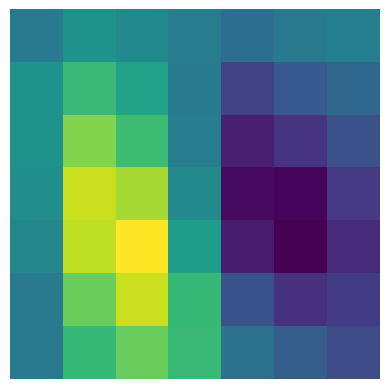

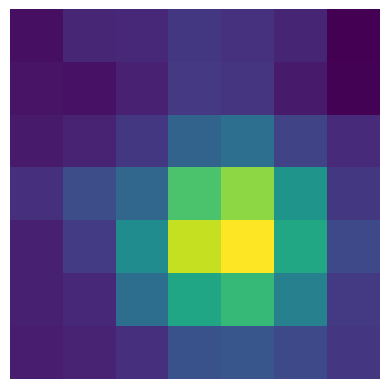

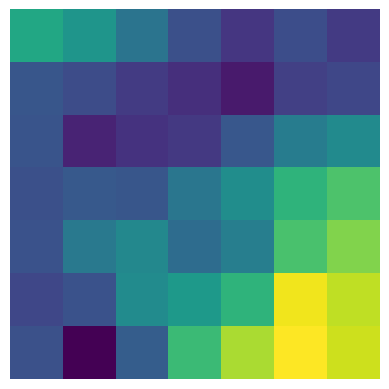

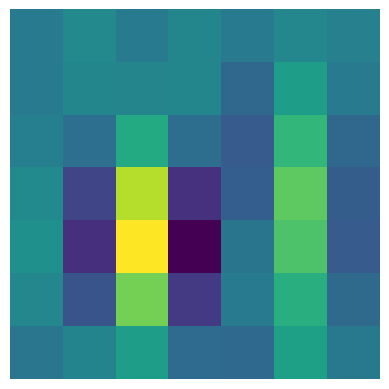

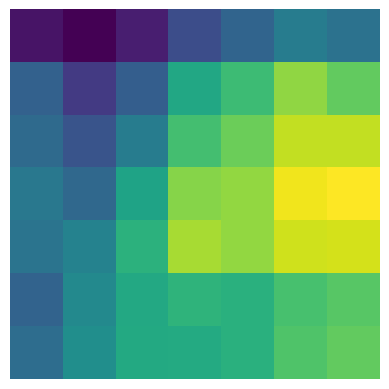

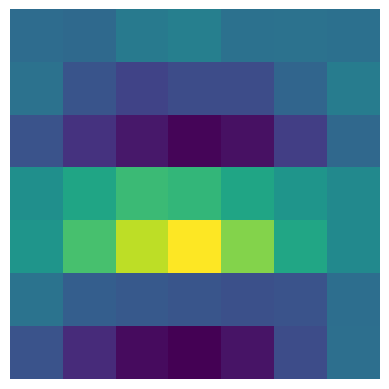

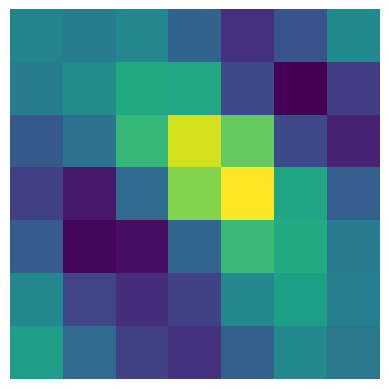

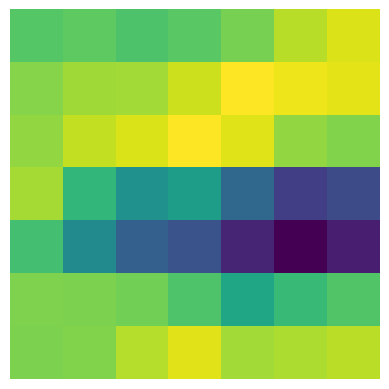

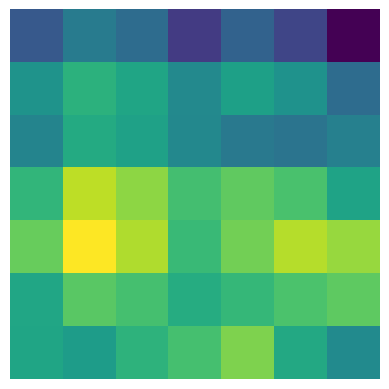

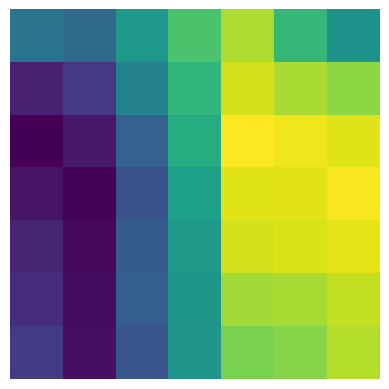

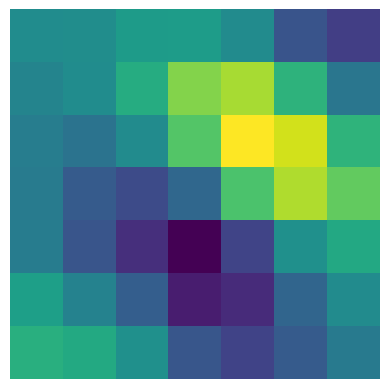

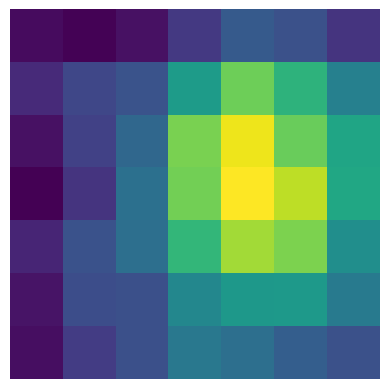

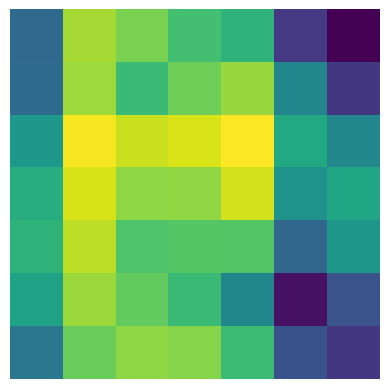

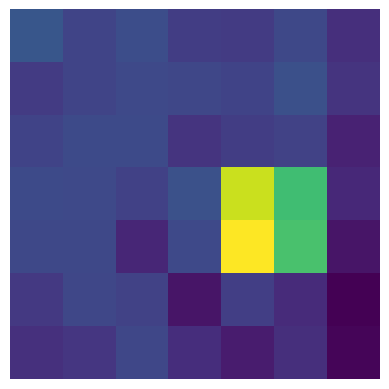

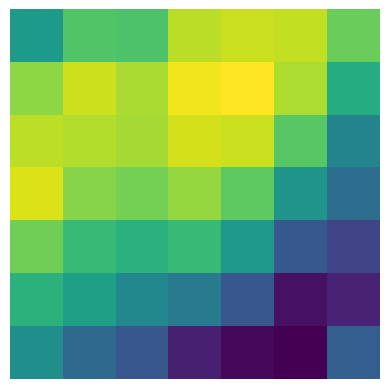

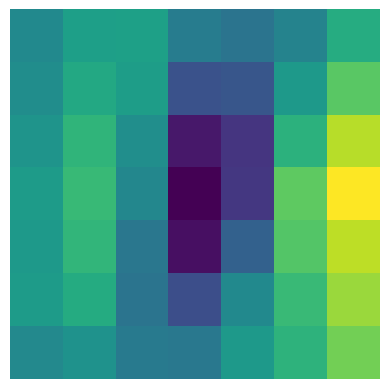

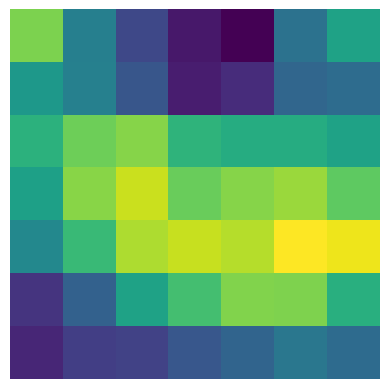

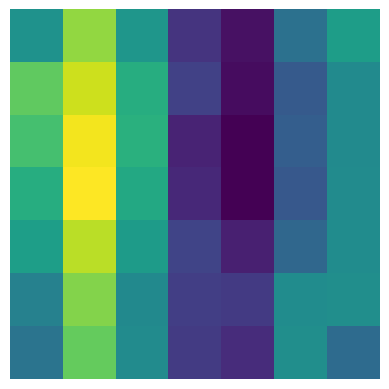

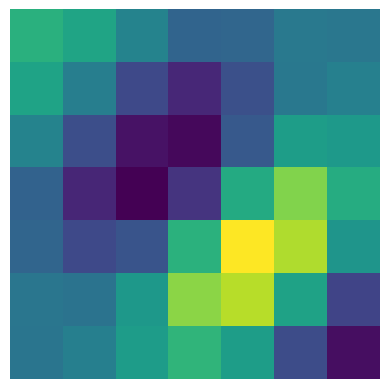

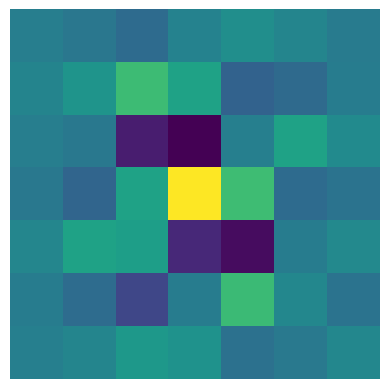

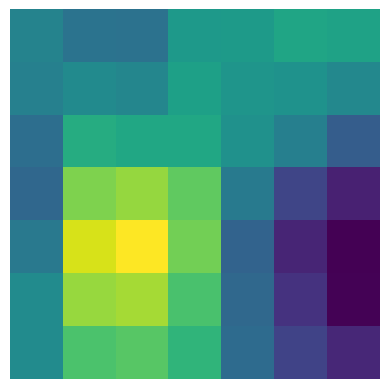

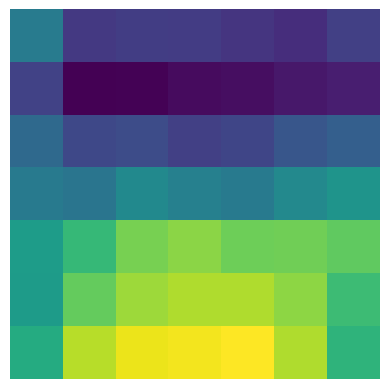

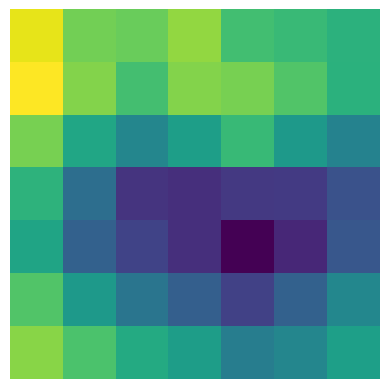

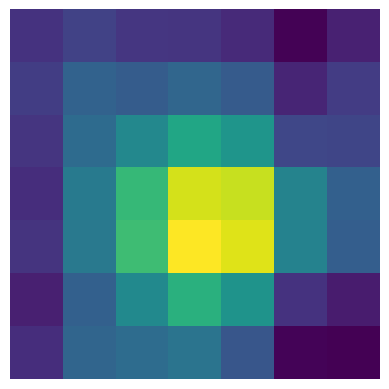

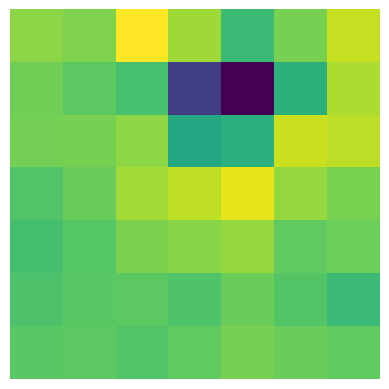

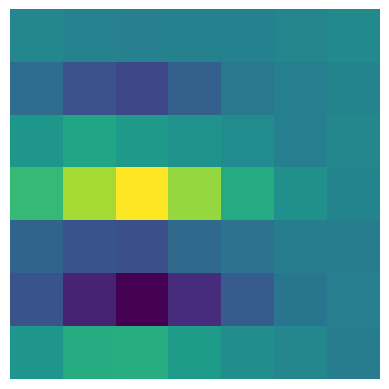

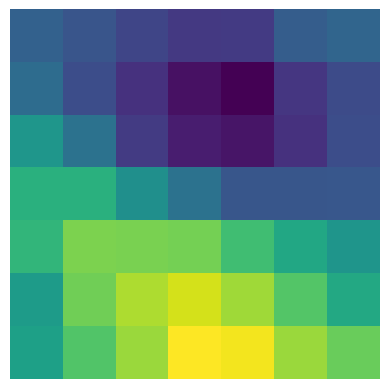

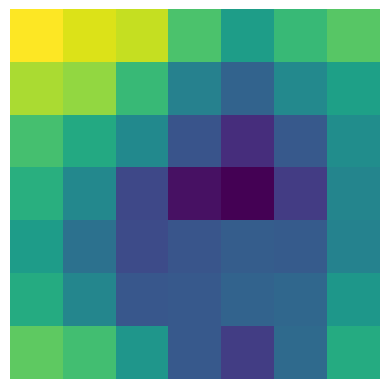

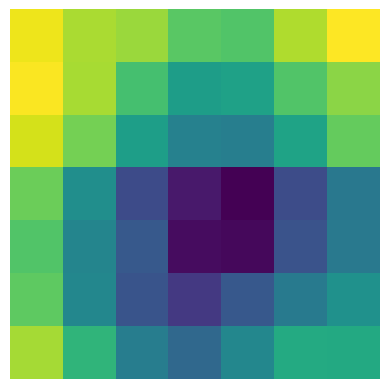

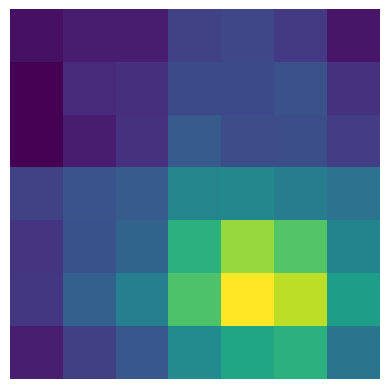

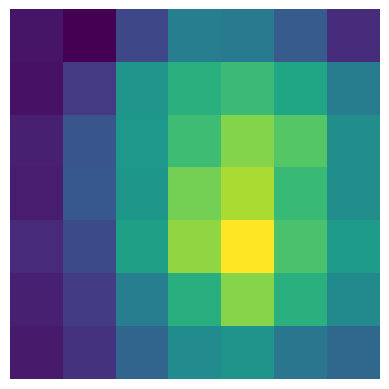

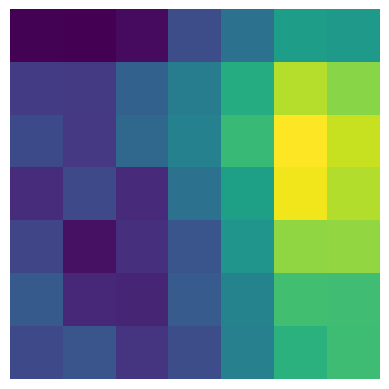

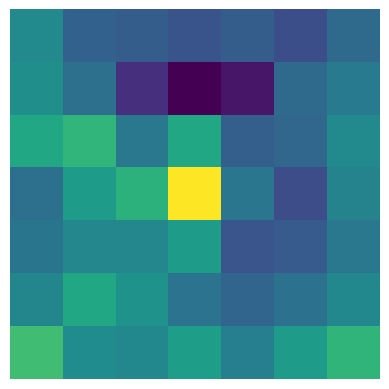

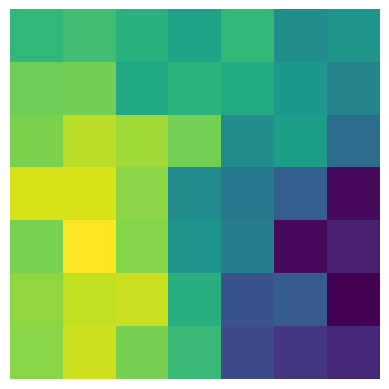

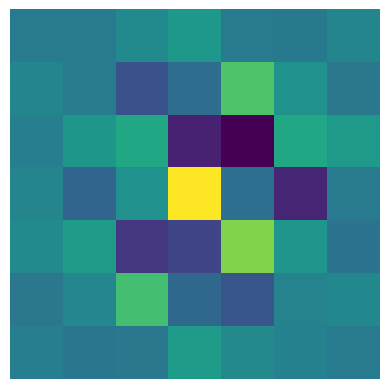

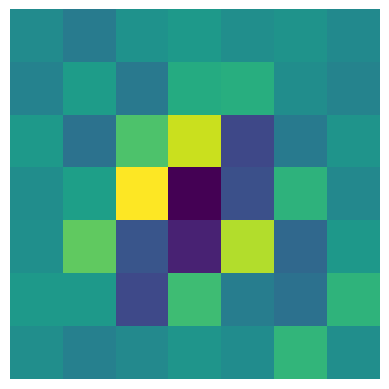

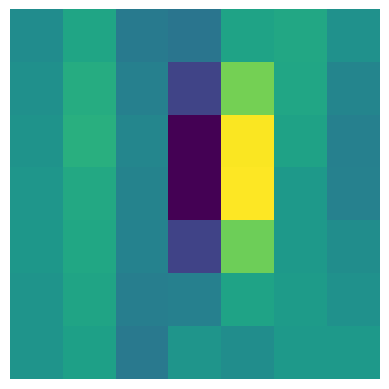

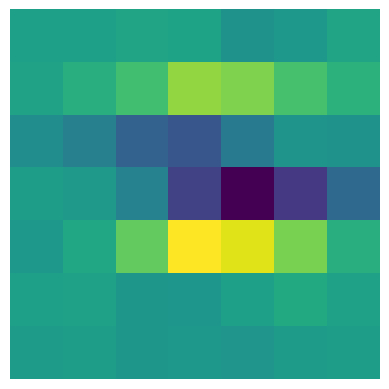

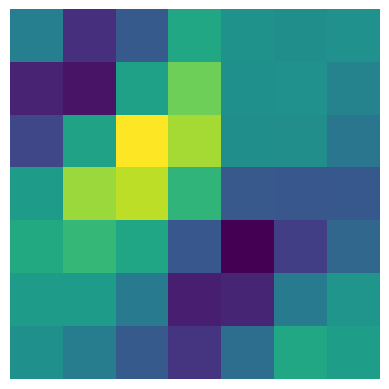

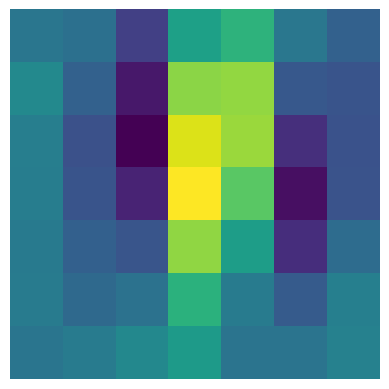

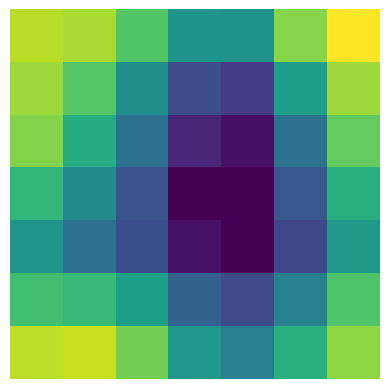

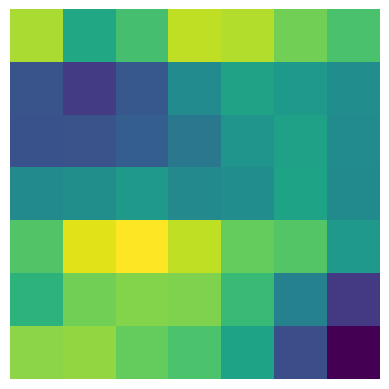

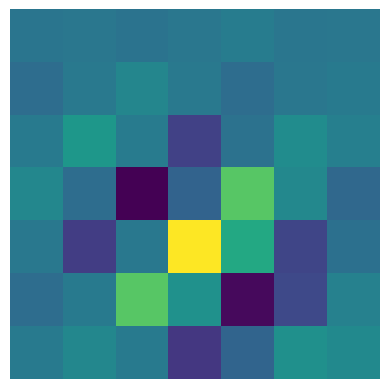

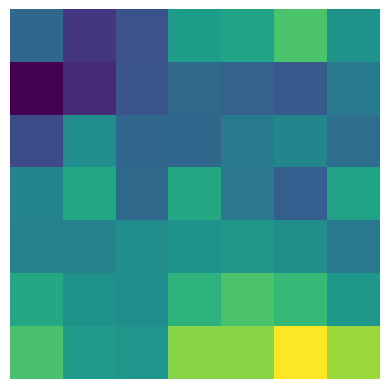

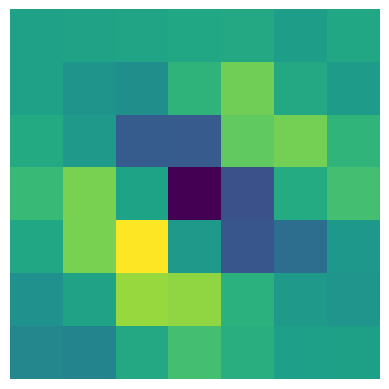

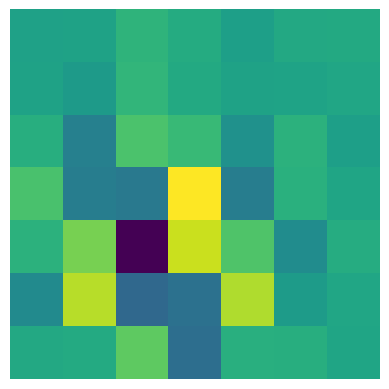

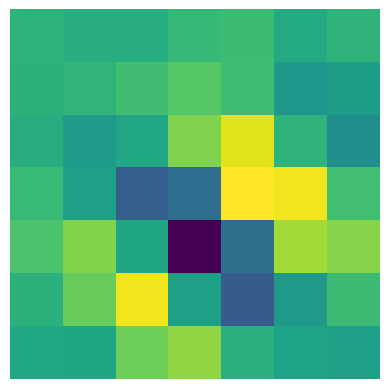

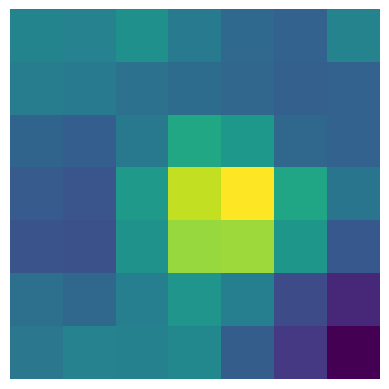

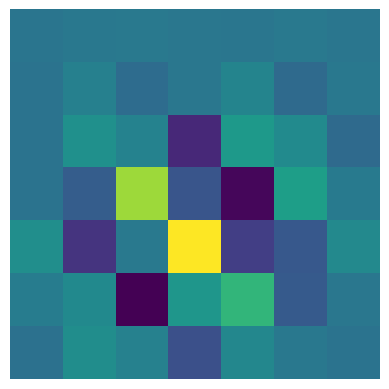

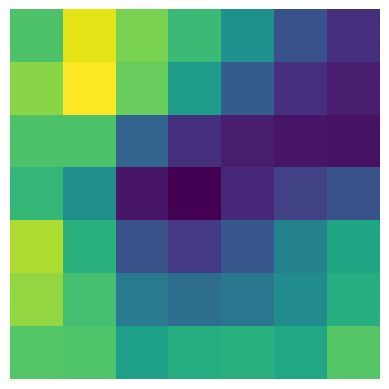

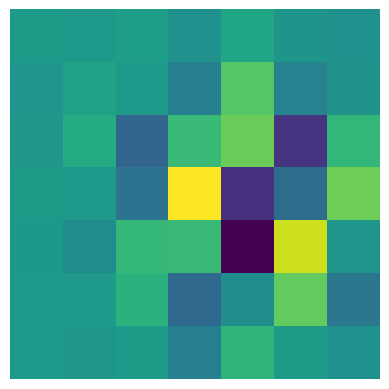

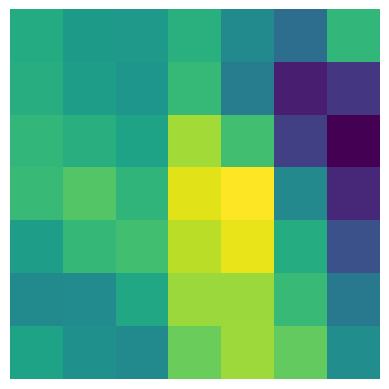

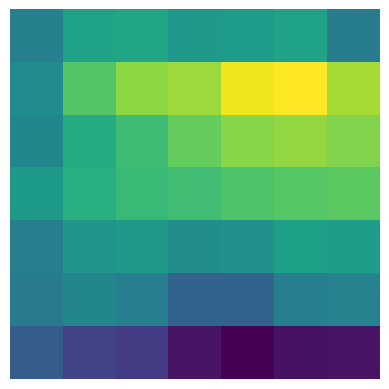

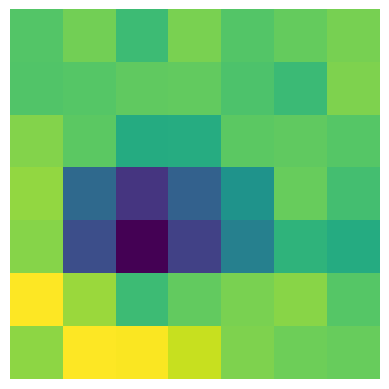

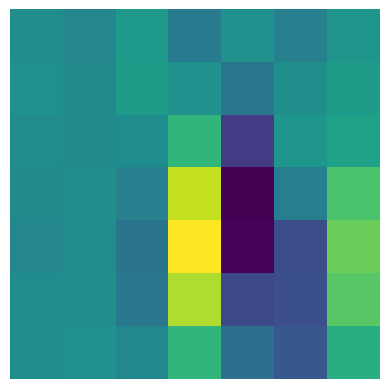

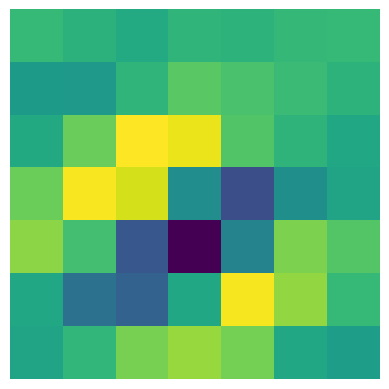

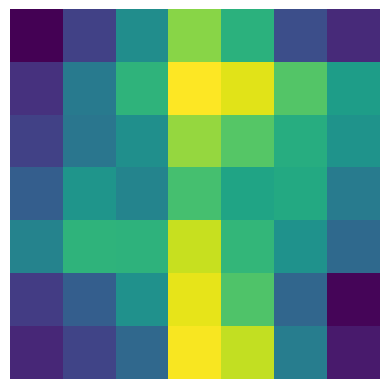

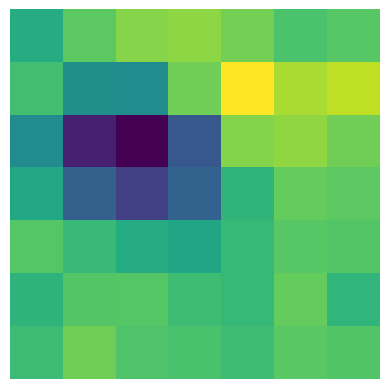

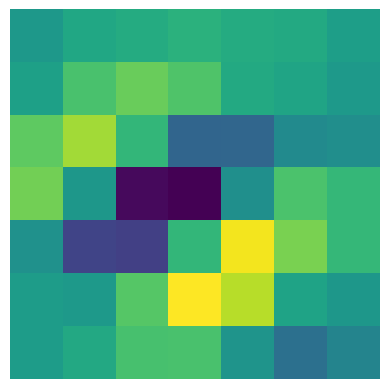

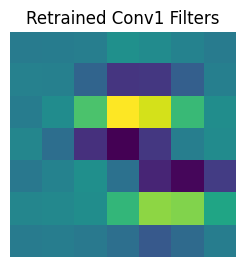

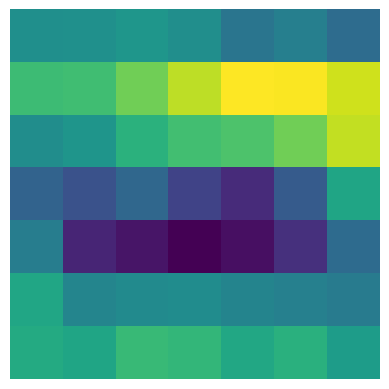

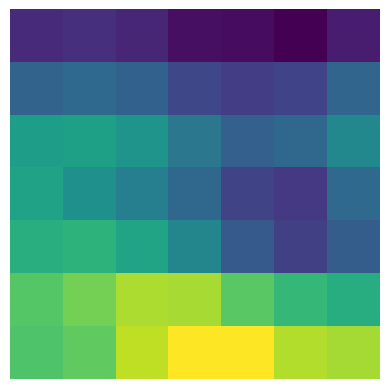

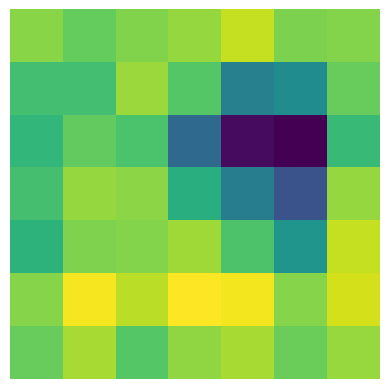

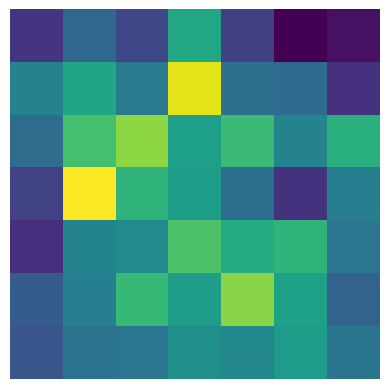

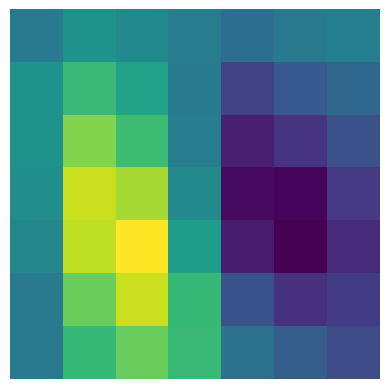

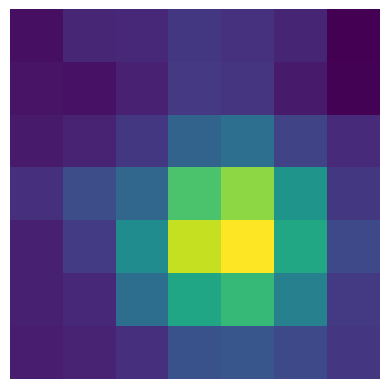

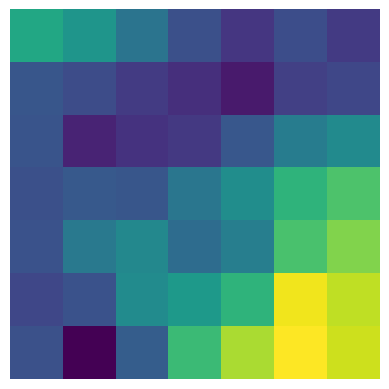

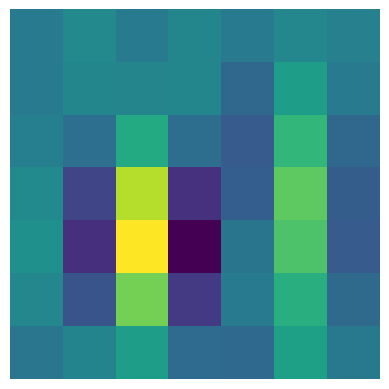

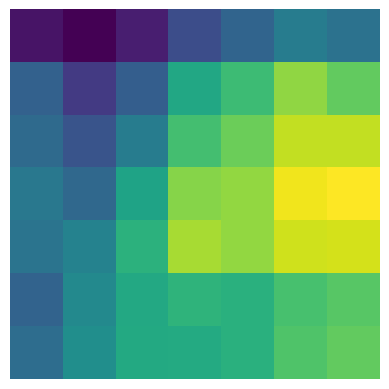

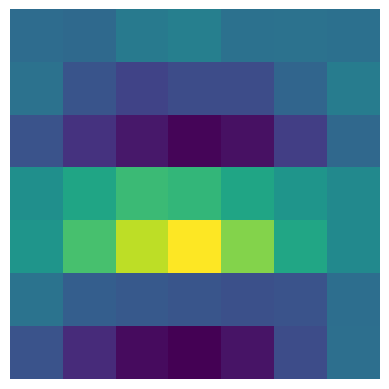

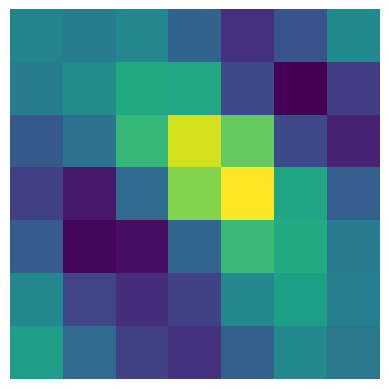

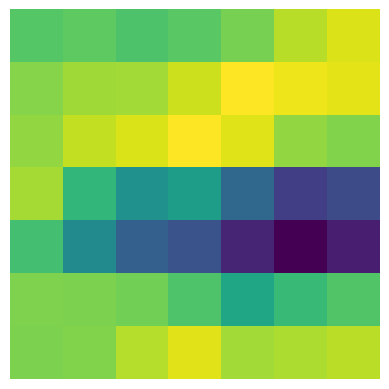

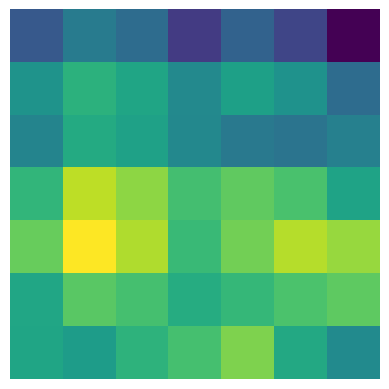

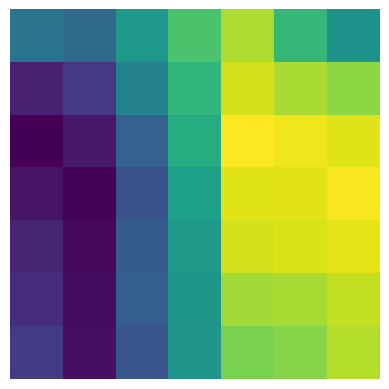

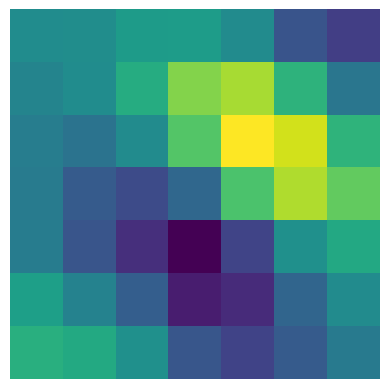

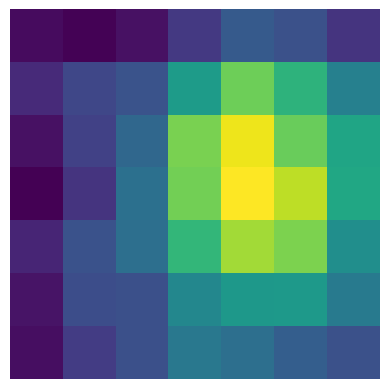

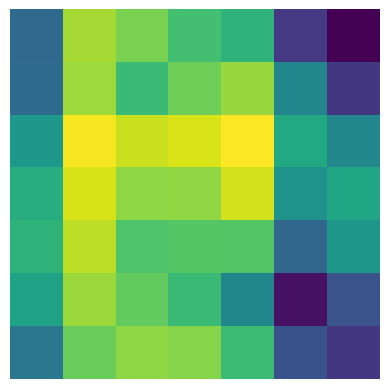

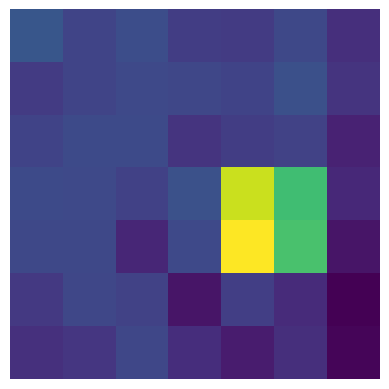

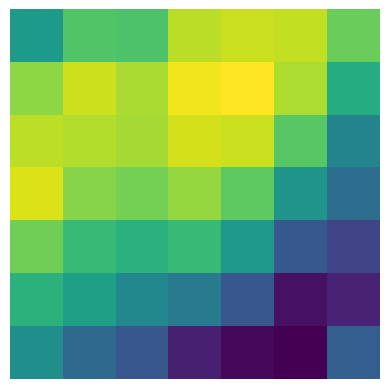

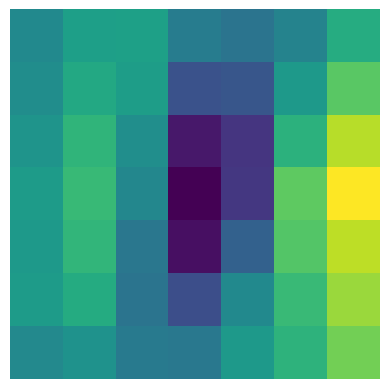

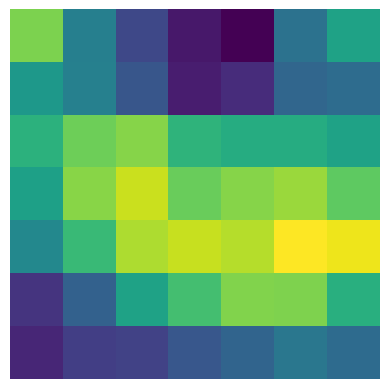

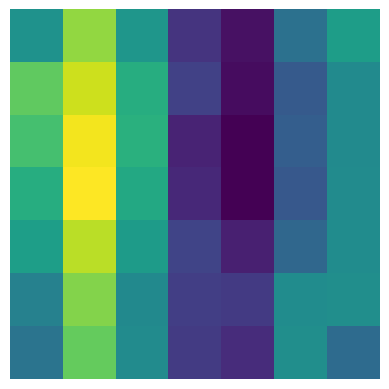

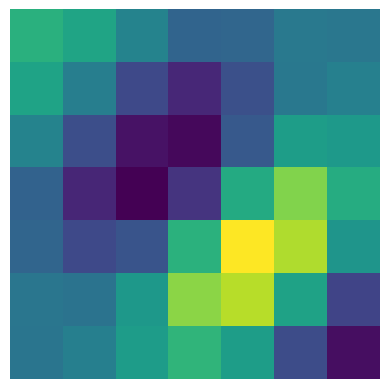

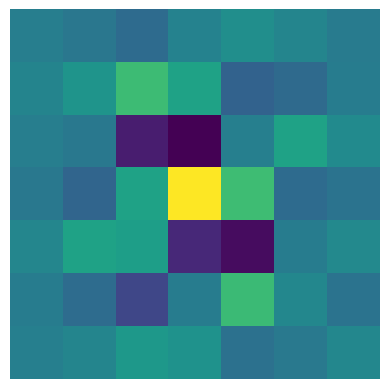

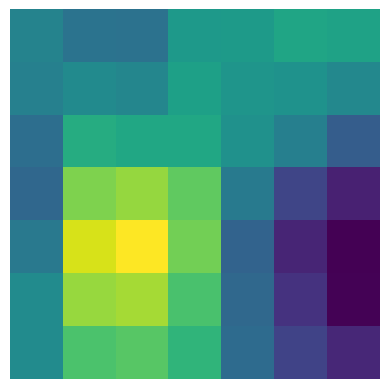

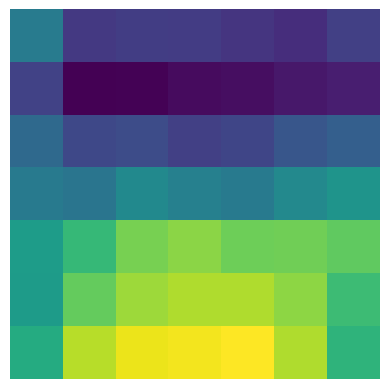

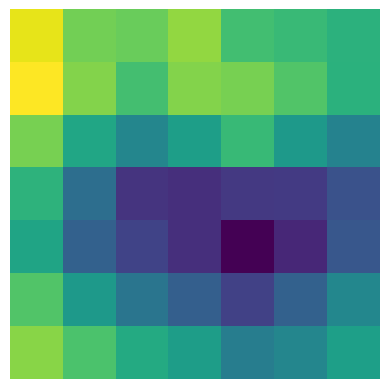

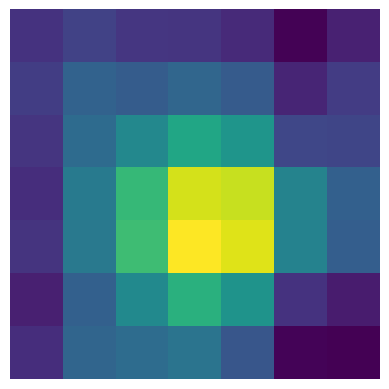

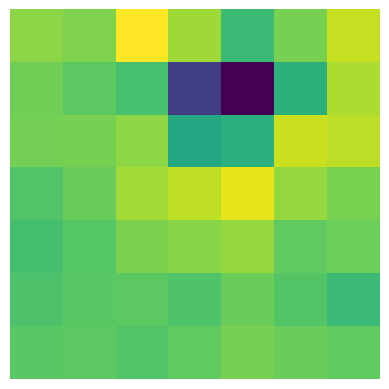

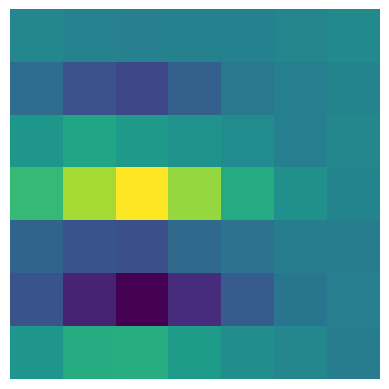

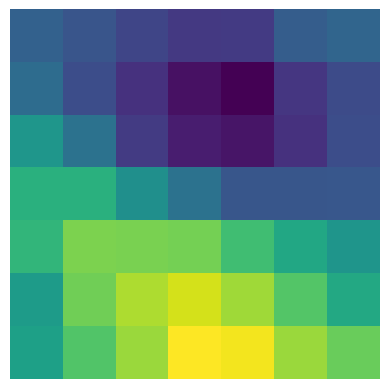

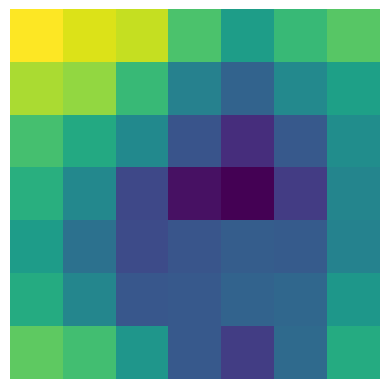

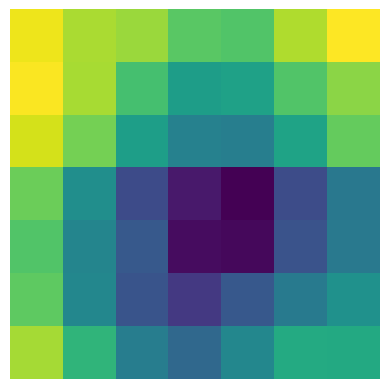

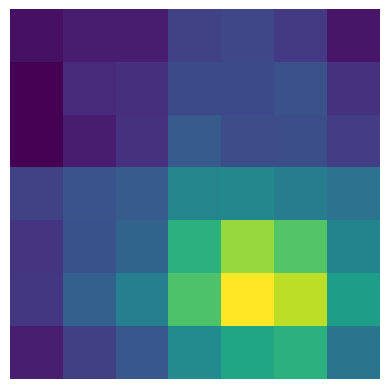

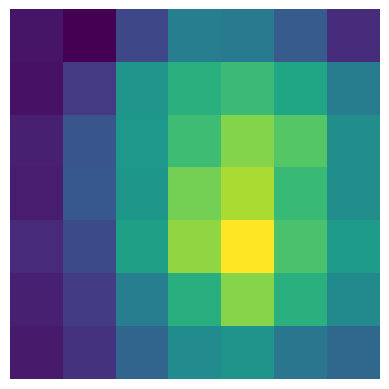

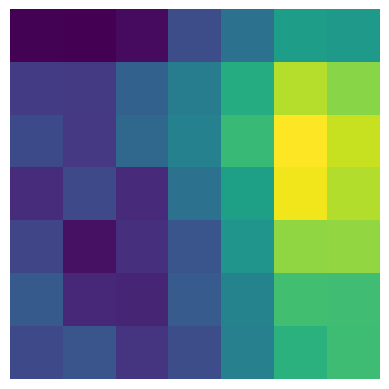

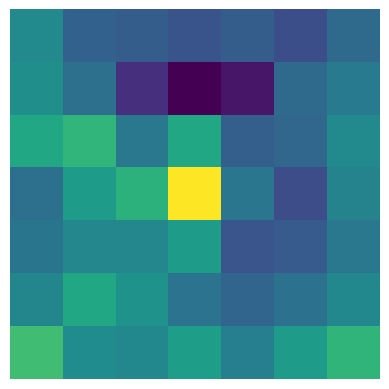

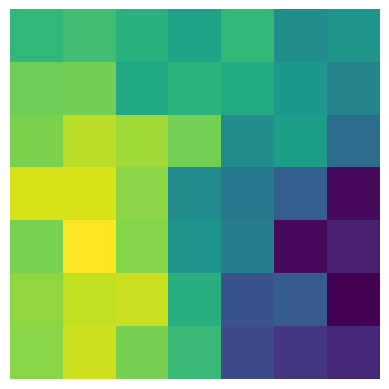

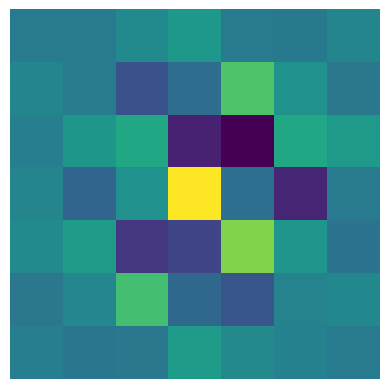

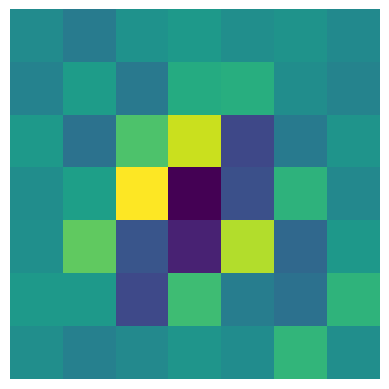

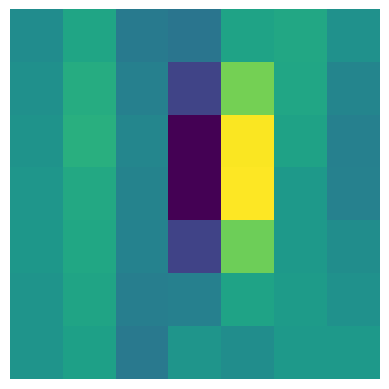

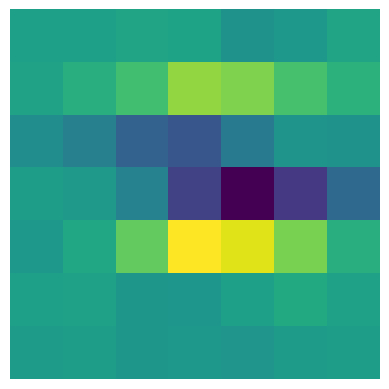

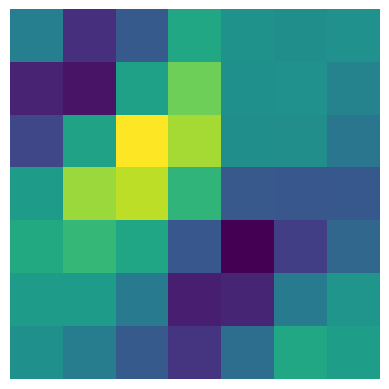

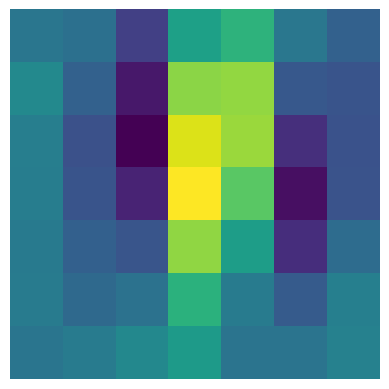

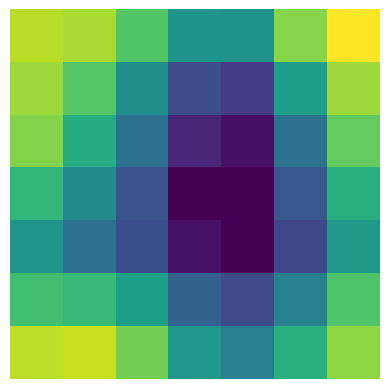

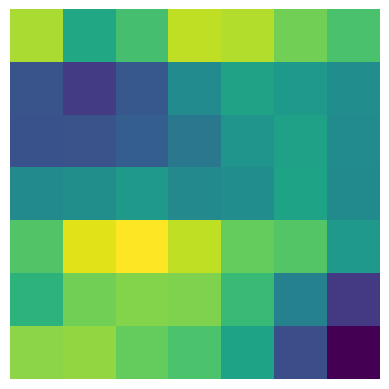

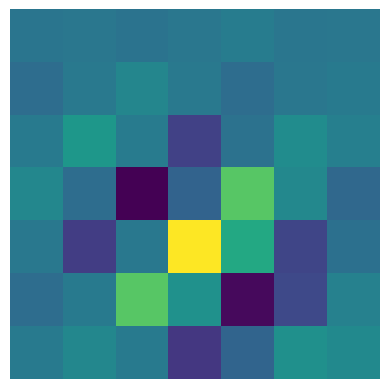

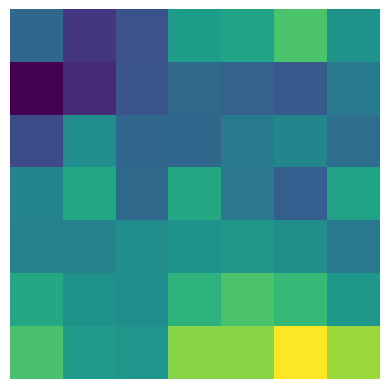

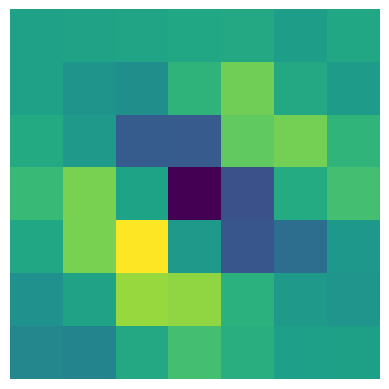

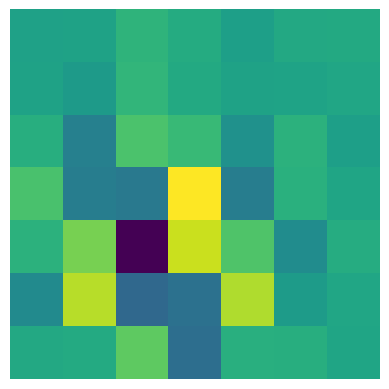

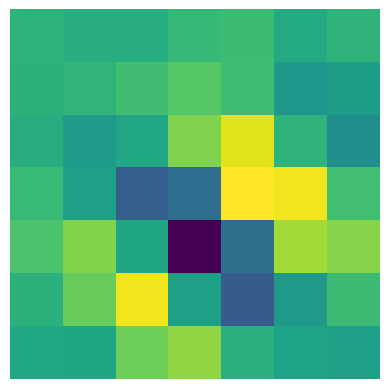

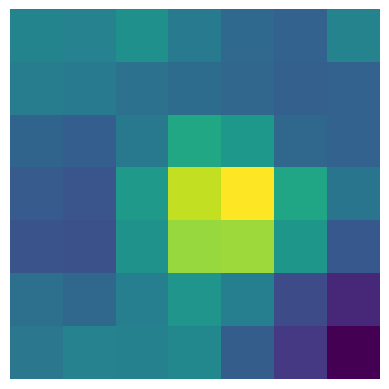

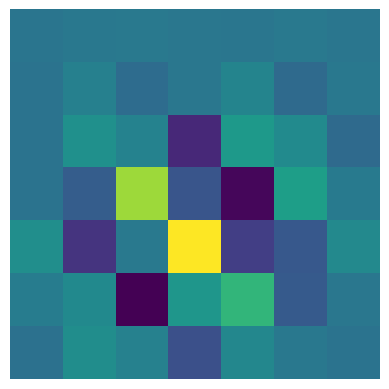

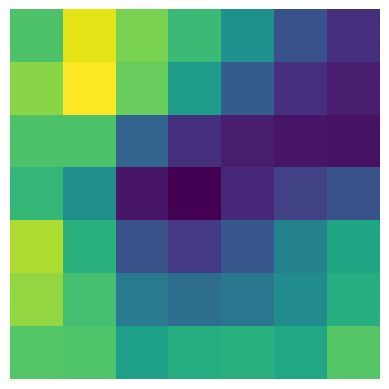

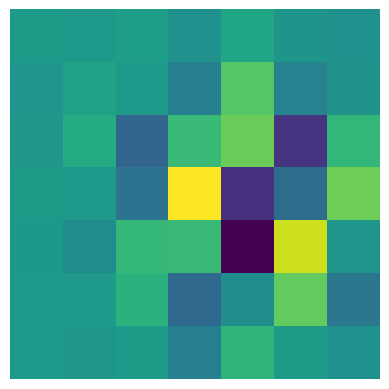

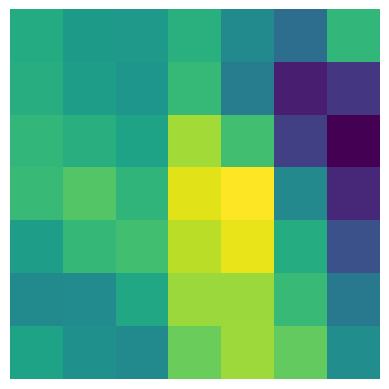

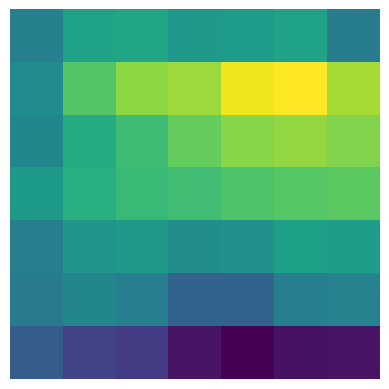

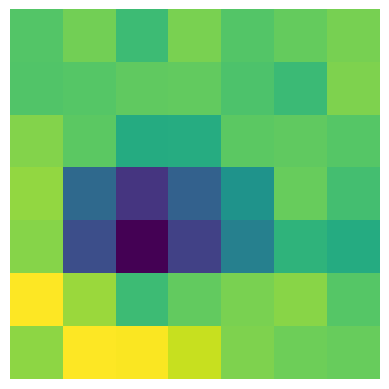

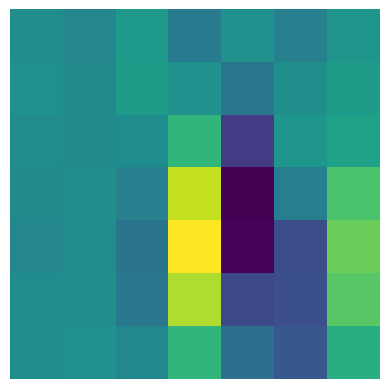

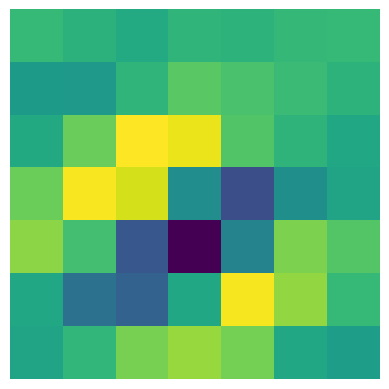

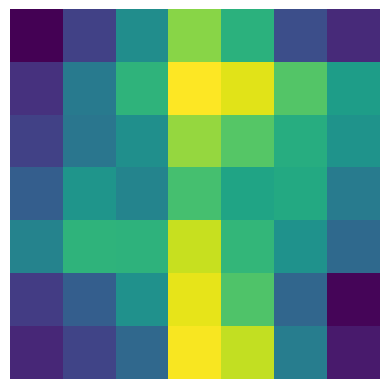

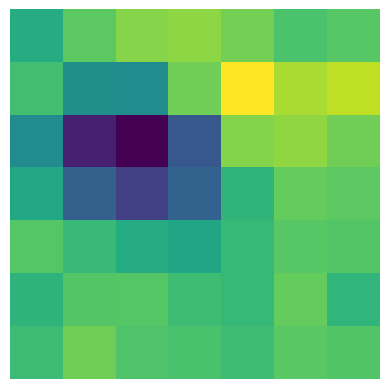

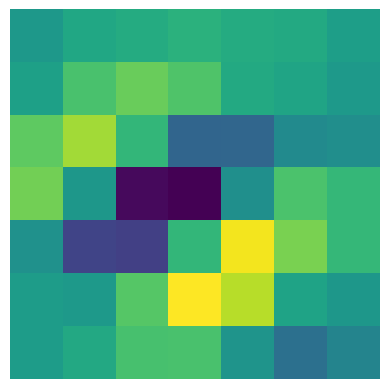

In [89]:
# Plot and compare the filters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Conv1 Filters")
for i in range(original_conv1_weights.shape[0]):
    plt.imshow(original_conv1_weights[i, 0], cmap='viridis')
    plt.axis('off')
    plt.show()

plt.subplot(1, 2, 2)
plt.title("Retrained Conv1 Filters")
for i in range(retrained_conv1_weights.shape[0]):
    plt.imshow(retrained_conv1_weights[i, 0], cmap='viridis')
    plt.axis('off')
    plt.show()